Final panel shape: (6840, 40)
   gvkey    datadate  fyear                  conm    tic      act      lct  \
0  10005  1996-12-31   1996  STANDARD REGISTER CO  SRCTQ  344.987   85.839   
1  10005  1997-12-31   1997  STANDARD REGISTER CO  SRCTQ  378.818  107.019   
2  10005  1998-12-31   1998  STANDARD REGISTER CO  SRCTQ  473.795  130.356   
3  10005  1999-12-31   1999  STANDARD REGISTER CO  SRCTQ  477.580  113.937   
4  10005  2000-12-31   2000  STANDARD REGISTER CO  SRCTQ  484.253  113.582   

        at       lt      seq  ...  us_cpi___all_urban:_all_items_sadj  \
0  588.113  134.867  453.246  ...                             156.858   
1  647.018  159.083  487.935  ...                             160.525   
2  985.077  464.112  520.965  ...                             163.008   
3  961.639  419.908  541.731  ...                             166.583   
4  902.606  408.452  494.154  ...                             172.192   

   us_treasury_bill_rate___3_month_(ep)_nadj  \
0             

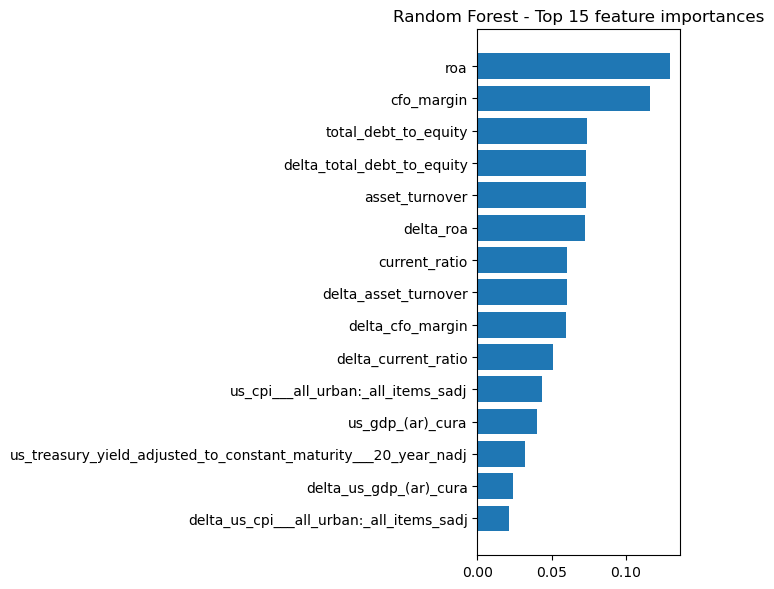


===== XGBoost =====
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1396
           1       0.73      0.64      0.68       656

    accuracy                           0.81      2052
   macro avg       0.79      0.77      0.77      2052
weighted avg       0.81      0.81      0.81      2052

AUC: 0.879212820602418
Confusion matrix:
 [[1243  153]
 [ 235  421]]


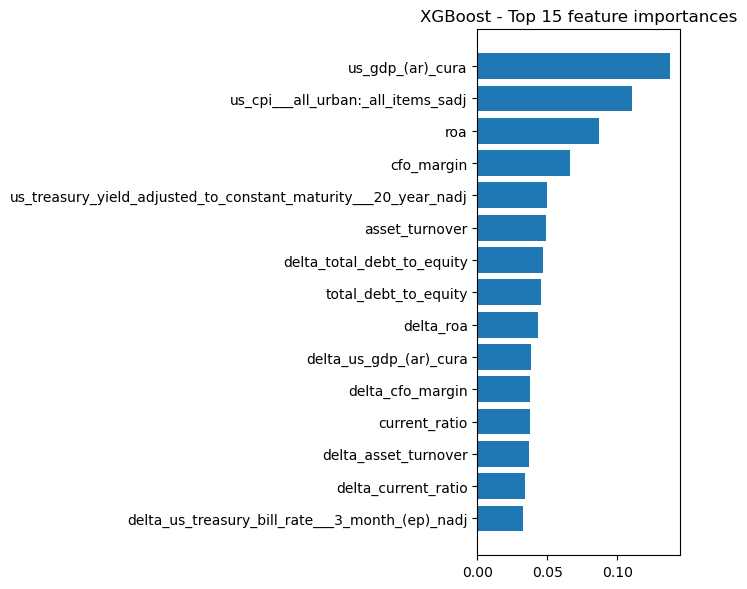

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import xgboost as xgb


# =========================
# 1. Load final panel
# =========================

base = "/files/financial-kpis-analysis-and-distress-prediction/"
data_path = os.path.join(base, "data/final/panel_balanced_with_deltas.csv")

df = pd.read_csv(data_path)
print("Final panel shape:", df.shape)
print(df.head())


# =========================
# 2. Build X and y using the actual columns
# =========================

# Target
y = df["y"].astype(int)
print("\nClass distribution in y:")
print(y.value_counts())

# --- Features we WANT to use ---
kpi_cols = [
    "roa",
    "total_debt_to_equity",
    "current_ratio",
    "cfo_margin",
    "asset_turnover",
]

delta_kpi_cols = [
    "delta_roa",
    "delta_total_debt_to_equity",
    "delta_current_ratio",
    "delta_cfo_margin",
    "delta_asset_turnover",
]

macro_cols = [
    "us_gdp_(ar)_cura",
    "us_cpi___all_urban:_all_items_sadj",
    "us_treasury_bill_rate___3_month_(ep)_nadj",
    "us_treasury_yield_adjusted_to_constant_maturity___20_year_nadj",
    "us_unemployment_rate_sadj",
]

delta_macro_cols = [
    "delta_us_gdp_(ar)_cura",
    "delta_us_cpi___all_urban:_all_items_sadj",
    "delta_us_treasury_bill_rate___3_month_(ep)_nadj",
    "delta_us_treasury_yield_adjusted_to_constant_maturity___20_year_nadj",
    "delta_us_unemployment_rate_sadj",
]

feature_cols = kpi_cols + delta_kpi_cols + macro_cols + delta_macro_cols

X = df[feature_cols].copy()   # uniquement KPIs + ΔKPIs + macro + Δmacro

print("\nX shape:", X.shape)
print("Any NaN in X ? ->", X.isna().any().any())

feature_names = X.columns.tolist()


# =========================
# 3. Train / test split
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("\nTrain size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

print("\nClass distribution in y_train:")
print(y_train.value_counts())
print("\nClass distribution in y_test:")
print(y_test.value_counts())


# =========================
# 4. Logistic Regression
# =========================

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Imputation des NaN
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# 2. Standardisation
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_imp)
X_test_lr = scaler.transform(X_test_imp)

# 3. Modèle
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_lr, y_train)

# 4. Évaluation
y_pred_lr = logreg.predict(X_test_lr)
y_proba_lr = logreg.predict_proba(X_test_lr)[:, 1]

print("===== Logistic Regression =====")
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_proba_lr))
print(confusion_matrix(y_test, y_pred_lr))



# =========================
# 5. Random Forest
# =========================

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n===== Random Forest =====")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_proba_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix:\n", cm_rf)

# Feature importance RF
importances_rf = rf.feature_importances_
idx_rf = np.argsort(importances_rf)[-15:]  # top 15

plt.figure(figsize=(7, 6))
plt.barh(np.array(feature_names)[idx_rf], importances_rf[idx_rf])
plt.title("Random Forest - Top 15 feature importances")
plt.tight_layout()
plt.show()


# =========================
# 6. XGBoost
# =========================

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n===== XGBoost =====")
print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion matrix:\n", cm_xgb)

# Feature importance XGB
xgb_importances = xgb_model.feature_importances_
idx_xgb = np.argsort(xgb_importances)[-15:]

plt.figure(figsize=(7, 6))
plt.barh(np.array(feature_names)[idx_xgb], xgb_importances[idx_xgb])
plt.title("XGBoost - Top 15 feature importances")
plt.tight_layout()
plt.show()
